## Importing dependencies

In [22]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from xgboost import XGBClassifier

# 1. Prepare Features and Target

In [23]:
df = pd.read_csv("diabetes_dataset.csv")

In [24]:
df = df.drop(columns=['ID'])  # Drop ID

X = df.drop('Diabetes_binary', axis=1)
y = df['Diabetes_binary']

In [25]:
# One-hot encode categorical variables (BMI_Category, Age_Group)
X = pd.get_dummies(X, drop_first=True)

## 2. Train-Test Split

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## 3. Scaling

In [27]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 4. Feature Selection

In [39]:
# Consistently using DataFrames (with feature names)
k_best = SelectKBest(score_func=f_classif, k=20)
X_train_selected = k_best.fit_transform(X_train, y_train)
X_test_selected = k_best.transform(X_test)


selected_features = X.columns[k_best.get_support()]
print("Selected Features:")
print(selected_features)

Selected Features:
Index(['HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke',
       'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'NoDocbcCost', 'GenHlth', 'MentHlth', 'PhysHlth',
       'DiffWalk', 'Sex', 'Age', 'Education', 'Income'],
      dtype='object')


## 5. XGBoost + Hyperparameter Tuning

In [40]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1],
}

grid = GridSearchCV(xgb, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
grid.fit(X_train_selected, y_train)

print("Best Parameters:", grid.best_params_)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


c:\diabetes_prediction\myenv\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:03:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}


## 6. Final Model Training

In [41]:
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test_selected)

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.98      0.93     43667
           1       0.56      0.16      0.25      7069

    accuracy                           0.87     50736
   macro avg       0.72      0.57      0.59     50736
weighted avg       0.83      0.87      0.83     50736

Accuracy: 0.8653618732261117


### 👉 Confusion Matrix

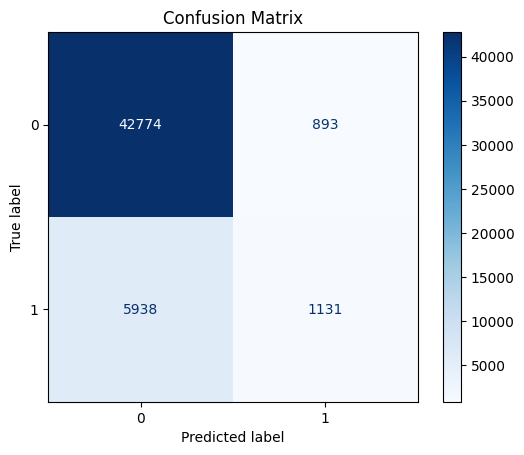

In [42]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


In [44]:
y_pred = best_model.predict(X_test_selected)
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)


Confusion Matrix:
 [[42774   893]
 [ 5938  1131]]


# saving the model

In [45]:
import joblib
# 👉 Save the model
joblib.dump(best_model, 'xgboost_diabetes_model.pkl')

['xgboost_diabetes_model.pkl']

In [46]:
X_test.to_csv('X_test_selected.csv', index=False)

Index(['HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke',
       'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education',
       'Income'],
      dtype='object')

In [47]:
df.head()

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0,1,1,1,40,1,0,0,0,0,...,1,0,5,18,15,1,0,9,4,3
1,0,0,0,0,25,1,0,0,1,0,...,0,1,3,0,0,0,0,7,6,1
2,0,1,1,1,28,0,0,0,0,1,...,1,1,5,30,30,1,0,9,4,8
3,0,1,0,1,27,0,0,0,1,1,...,1,0,2,0,0,0,0,11,3,6
4,0,1,1,1,24,0,0,0,1,1,...,1,0,2,3,0,0,0,11,5,4
